In [ ]:
import gdown
gdown.download('https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5',  'facenet512_weights.h5', quiet=False)

In [ ]:
import gdown
gdown.download('<dataset_download_link>',  'AllData.zip', quiet=False)

In [10]:
## Unzip AllData.zip
!unzip -qq AllData.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Import Packages

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Lambda, add, GlobalAveragePooling2D, Convolution2D, LocallyConnected2D, ZeroPadding2D, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow_addons.metrics import F1Score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-01-27 02:33:15.651831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 02:33:18.050850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 02:33:18.051509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Read labels

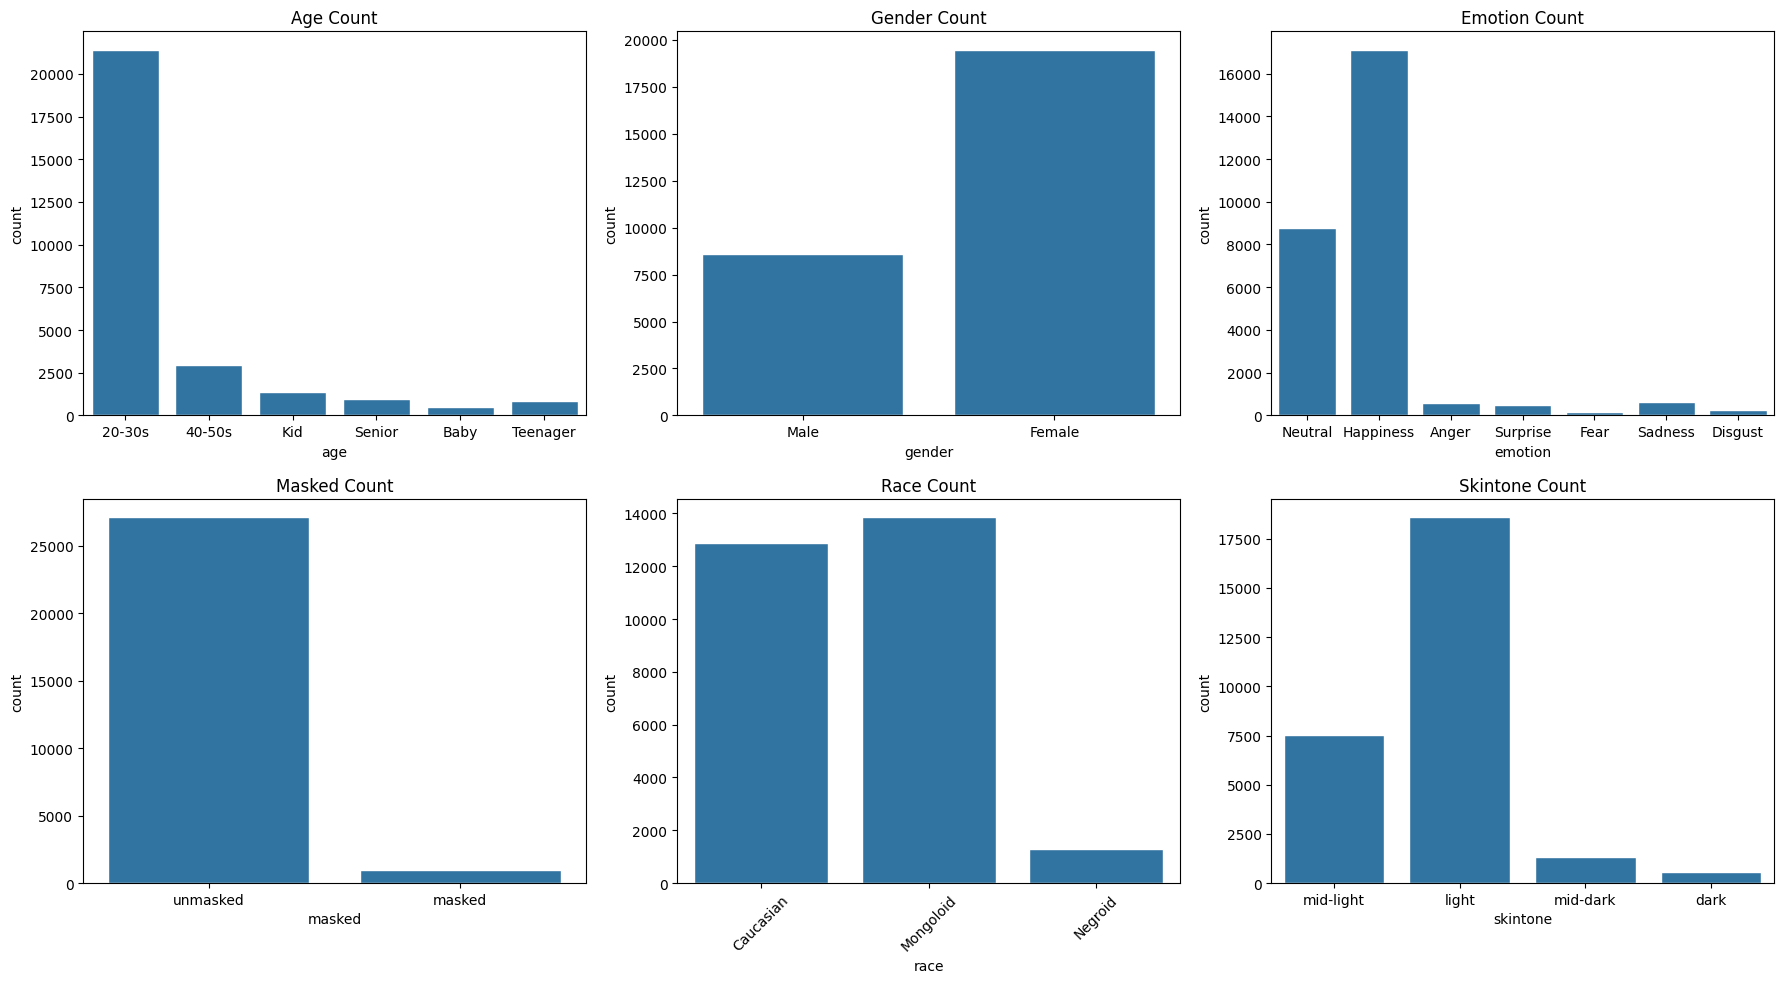

In [3]:


# Load CSV file
labels_df = pd.read_csv('all_data_labels.csv')

def plot_distributions(target_df):
  # Create subplots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
  sns.set(style="darkgrid")

  # Plot age count
  sns.countplot(x="age", data=target_df, ax=axes[0, 0])
  axes[0, 0].set_title("Age Count")

  # Plot gender count
  sns.countplot(x="gender", data=target_df, ax=axes[0, 1])
  axes[0, 1].set_title("Gender Count")

  # Plot emotion count
  sns.countplot(x="emotion", data=target_df, ax=axes[0, 2])
  axes[0, 2].set_title("Emotion Count")

  # Plot masked count
  sns.countplot(x="masked", data=target_df, ax=axes[1, 0])
  axes[1, 0].set_title("Masked Count")

  # Plot race count
  sns.countplot(x="race", data=target_df, ax=axes[1, 1])
  axes[1, 1].set_title("Race Count")
  axes[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

  # Plot skintone count
  sns.countplot(x="skintone", data=target_df, ax=axes[1, 2])
  axes[1, 2].set_title("Skintone Count")

  # Adjust layout
  plt.tight_layout()

  # Show the plots
  plt.show()

plot_distributions(labels_df)

In [4]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

def balance_attributes(target_df, attribute = 'age'):
  # Separate the dataset into features and target variable
  # Assuming 'age' is the target variable and other columns are features
  X = target_df.drop(attribute, axis=1)
  y = target_df[attribute]

  # Initialize the RandomOverSampler
  ros = RandomOverSampler(random_state=42)

  # Resample the dataset
  X_resampled, y_resampled = ros.fit_resample(X, y)

  # Combine the resampled features and target into a new DataFrame
  balanced_labels_df = pd.concat([X_resampled, y_resampled], axis=1)

  return balanced_labels_df



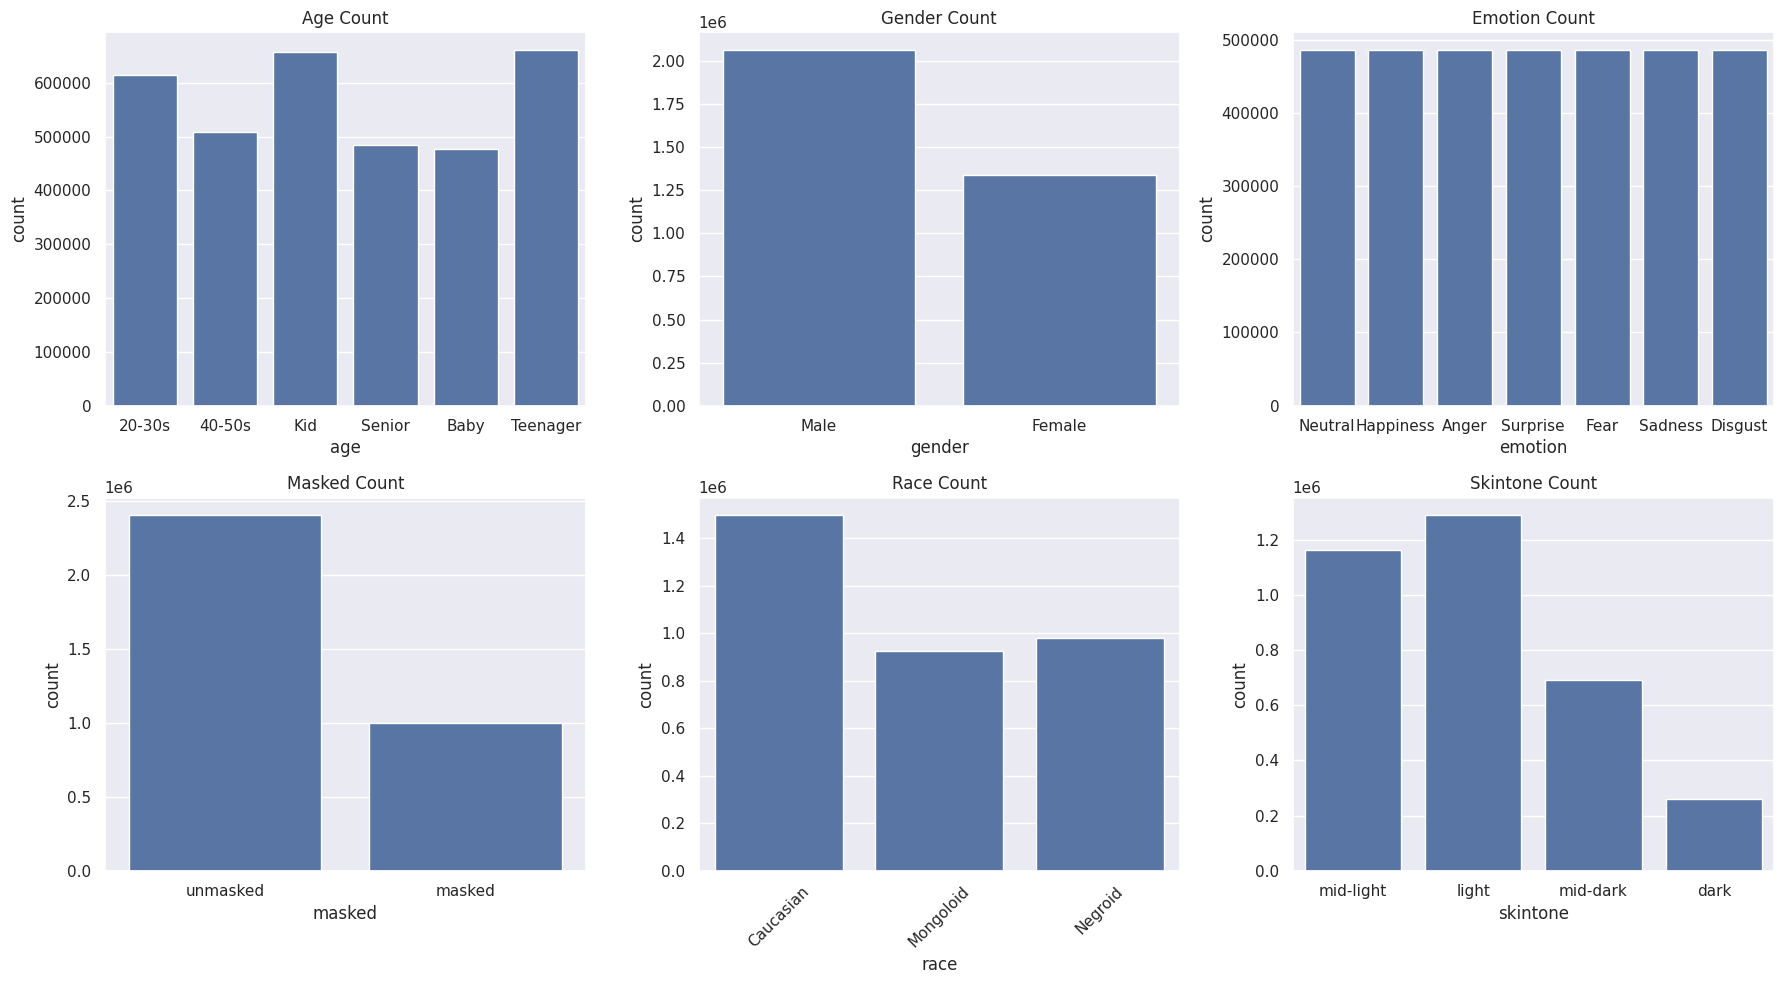

In [5]:
labels_df = balance_attributes(labels_df, "masked")
labels_df = balance_attributes(labels_df, "gender")
labels_df = balance_attributes(labels_df, "race")
labels_df = balance_attributes(labels_df, "skintone")
labels_df = balance_attributes(labels_df, "age")
labels_df = balance_attributes(labels_df, "emotion")

plot_distributions(labels_df)

In [6]:
labels_df.shape

(3402063, 8)

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.97, random_state=1)
for train_index, validation_index in sss.split(labels_df['file_name'], labels_df['age']):
    train_df, _ = labels_df.iloc[train_index], labels_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))

train_df shape: (102061, 8)


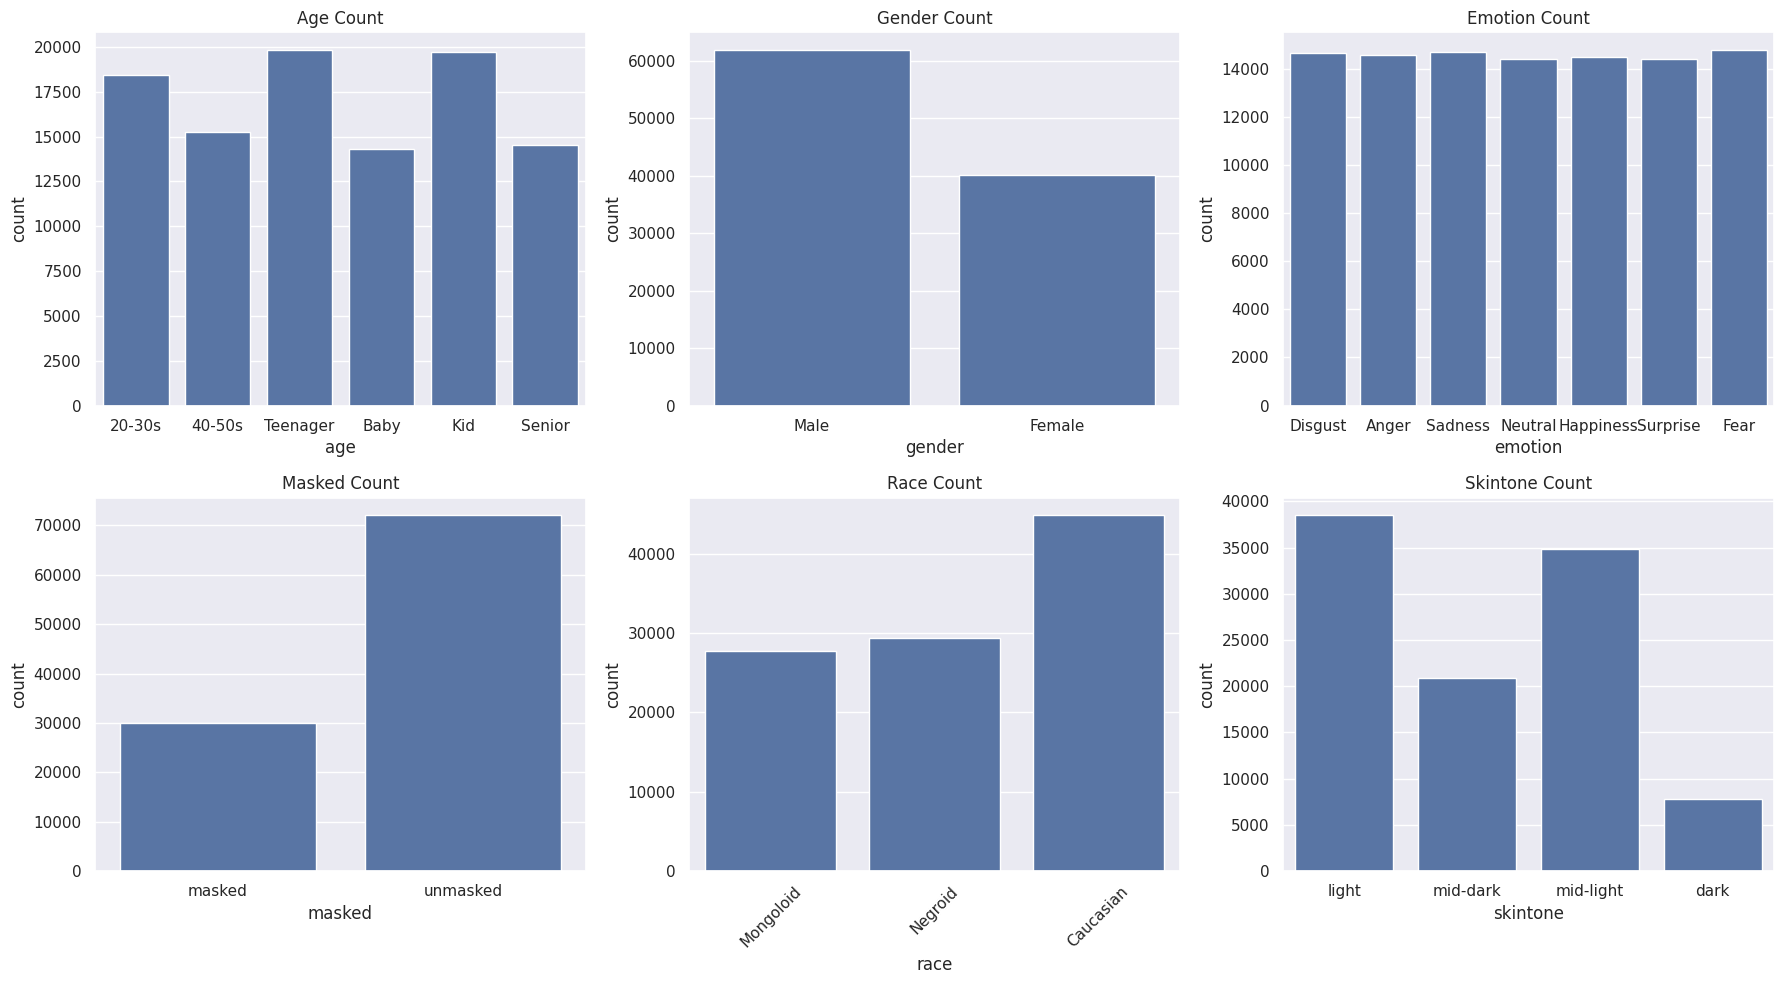

In [8]:
labels_df = train_df
plot_distributions(labels_df)

### Model Hyperparameters

In [9]:
train_dataset_dir = "AllData"
val_dataset_dir = "AllData"
mini_batch_size = 32
image_dim = (224, 224, 3)
val_split=0.15
num_of_epochs = 275
save_model_name = "multitask_attention_akatsuki.h5"
# pretrained_weights = "age_gender_CLAHE_224.h5"

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=1)
for train_index, validation_index in sss.split(labels_df['file_name'], labels_df['gender']):
    train_df, validation_df = labels_df.iloc[train_index], labels_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))
print("validation_df shape: {}".format(validation_df.shape))

train_df shape: (86751, 8)
validation_df shape: (15310, 8)


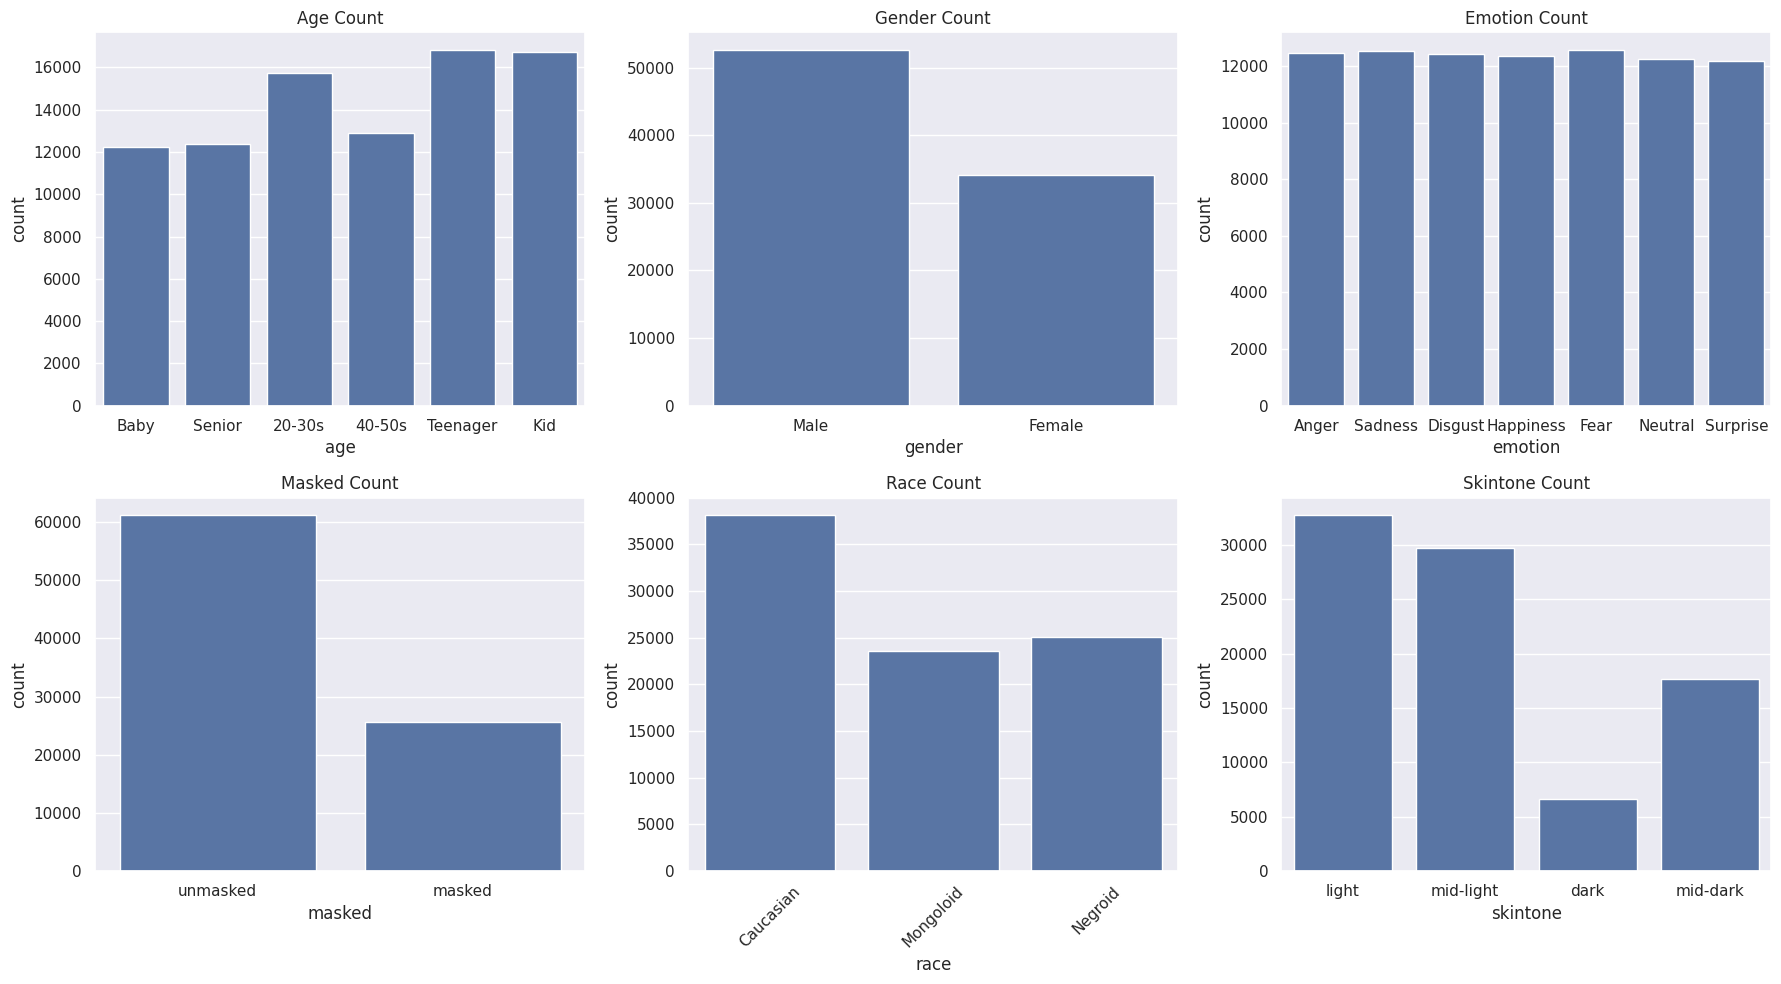

In [11]:
plot_distributions(train_df)

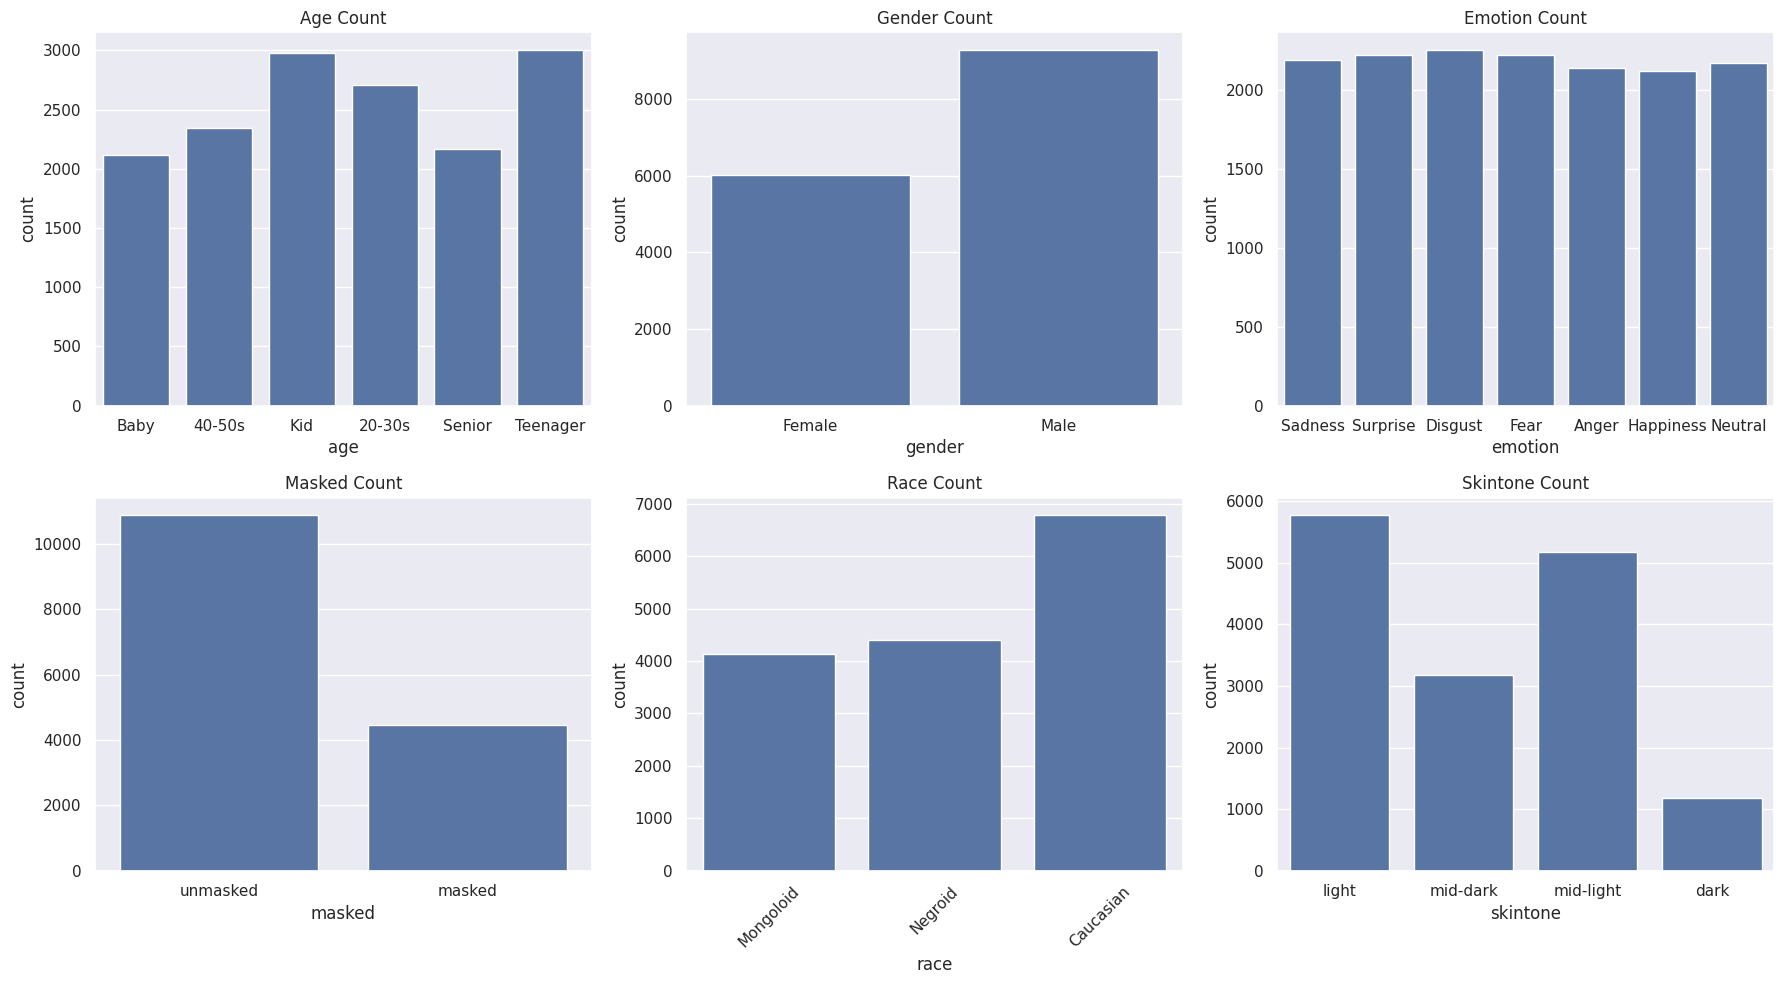

In [12]:
plot_distributions(validation_df)

In [13]:
train_df.head()

,source,file_name,masked,gender,race,skintone,age,emotion
1121719,public_train,11873_85015911.jpg,unmasked,Male,Caucasian,light,Baby,Anger
2897270,more_train_data,9178_82900593.jpg,unmasked,Male,Mongoloid,light,Baby,Sadness
1603304,more_train_data,10091_87483165.jpg,unmasked,Male,Mongoloid,mid-light,Senior,Disgust
1772826,public_train,10008_77607595.jpg,unmasked,Male,Negroid,dark,20-30s,Disgust
832335,public_train,11724_84422434.jpg,masked,Male,Negroid,mid-dark,Senior,Happiness


In [ ]:
# Map age ranges to numeric labels
age_mapping = {'20-30s': 0, '40-50s': 1, 'Baby': 2, 'Kid': 3, 'Senior': 4, 'Teenager': 5}
gender_mapping = {'Male': 0, 'Female': 1}
emotion_mapping = {
    'Anger': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happiness': 3,
    'Neutral': 4,
    'Sadness': 5,
    'Surprise': 6
}

masked_mapping = {
    'masked': 0,
    'unmasked': 1
}

race_mapping = {
    'Caucasian': 0,
    'Mongoloid': 1,
    'Negroid': 2
}

skintone_mapping = {
    'dark': 0,
    'light': 1,
    'mid-dark': 2,
    'mid-light': 3
}

train_df['age'] = train_df['age'].map(age_mapping)
train_df['age'] = train_df['age'].apply(lambda x: to_categorical(x, num_classes=6))

train_df['gender'] = train_df['gender'].map(gender_mapping)
train_df['gender'] = train_df['gender'].astype(int)

train_df['emotion'] = train_df['emotion'].map(emotion_mapping)
train_df['emotion'] = train_df['emotion'].apply(lambda x: to_categorical(x, num_classes=7))

train_df['masked'] = train_df['masked'].map(masked_mapping)
train_df['masked'] = train_df['masked'].astype(int)

train_df['race'] = train_df['race'].map(race_mapping)
train_df['race'] = train_df['race'].apply(lambda x: to_categorical(x, num_classes=3))

train_df['skintone'] = train_df['skintone'].map(skintone_mapping)
train_df['skintone'] = train_df['skintone'].apply(lambda x: to_categorical(x, num_classes=4))



validation_df['age'] = validation_df['age'].map(age_mapping)
validation_df['age'] = validation_df['age'].apply(lambda x: to_categorical(x, num_classes=6))

validation_df['gender'] = validation_df['gender'].map(gender_mapping)
validation_df['gender'] = validation_df['gender'].astype(int)

validation_df['emotion'] = validation_df['emotion'].map(emotion_mapping)
validation_df['emotion'] = validation_df['emotion'].apply(lambda x: to_categorical(x, num_classes=7))

validation_df['masked'] = validation_df['masked'].map(masked_mapping)
validation_df['masked'] = validation_df['masked'].astype(int)

validation_df['race'] = validation_df['race'].map(race_mapping)
validation_df['race'] = validation_df['race'].apply(lambda x: to_categorical(x, num_classes=3))

validation_df['skintone'] = validation_df['skintone'].map(skintone_mapping)
validation_df['skintone'] = validation_df['skintone'].apply(lambda x: to_categorical(x, num_classes=4))

### Config image generators

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=val_split
)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = train_dataset_dir,
    x_col = 'file_name',
    y_col = ['age', 'gender', 'emotion', 'masked', 'race', 'skintone'],
    class_mode = 'multi_output',
    target_size = (image_dim[0], image_dim[1]),
    interpolation="bicubic",
    batch_size = mini_batch_size
)


validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory = val_dataset_dir,
    x_col='file_name',
    y_col = ['age', 'gender', 'emotion', 'masked', 'race', 'skintone'],
    target_size = (image_dim[0], image_dim[1]),
    batch_size = mini_batch_size,
    class_mode = "multi_output",
    interpolation="bicubic",
    shuffle=False
)


Found 86751 validated image filenames.
Found 15310 validated image filenames.


### Build and validate the model


In [16]:
def scaling(x, scale):
	return x * scale

def InceptionResNetV2(input_shape):
	
	inputs = Input(shape=input_shape)
	x = Conv2D(32, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_1a_3x3') (inputs)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_1a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_1a_3x3_Activation')(x)
	x = Conv2D(32, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_2a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2a_3x3_Activation')(x)
	x = Conv2D(64, 3, strides=1, padding='same', use_bias=False, name= 'Conv2d_2b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_2b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_2b_3x3_Activation')(x)
	x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
	x = Conv2D(80, 1, strides=1, padding='valid', use_bias=False, name= 'Conv2d_3b_1x1') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_3b_1x1_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_3b_1x1_Activation')(x)
	x = Conv2D(192, 3, strides=1, padding='valid', use_bias=False, name= 'Conv2d_4a_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4a_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4a_3x3_Activation')(x)
	x = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Conv2d_4b_3x3') (x)
	x = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Conv2d_4b_3x3_BatchNorm')(x)
	x = Activation('relu', name='Conv2d_4b_3x3_Activation')(x)
	
	# 5x Block35 (Inception-ResNet-A block):
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_1_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_1_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_1_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_1_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_1_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_1_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_2_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_2_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_2_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_2_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_2_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_2_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_3_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_3_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_3_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_3_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_3_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_3_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_4_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_4_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_4_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_4_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_4_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_4_Activation')(x)
	
	branch_0 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block35_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block35_5_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_2 = Conv2D(32, 1, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(32, 3, strides=1, padding='same', use_bias=False, name= 'Block35_5_Branch_2_Conv2d_0c_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block35_5_Branch_2_Conv2d_0c_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Block35_5_Branch_2_Conv2d_0c_3x3_Activation')(branch_2)
	branches = [branch_0, branch_1, branch_2]
	mixed = Concatenate(axis=3, name='Block35_5_Concatenate')(branches)
	up = Conv2D(256, 1, strides=1, padding='same', use_bias=True, name= 'Block35_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.17})(up)
	x = add([x, up])
	x = Activation('relu', name='Block35_5_Activation')(x)

	# Mixed 6a (Reduction-A block):
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_0_Conv2d_1a_3x3') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_6a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_0b_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_0b_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_0b_3x3_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_6a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_6a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_6a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_6a_Branch_2_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_pool]
	x = Concatenate(axis=3, name='Mixed_6a')(branches)

	# 10x Block17 (Inception-ResNet-B block):
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_1_Branch_1_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_1_Branch_1_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_1_Branch_1_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_1_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_1_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_2_Branch_2_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_2_Branch_2_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_2_Branch_2_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_2_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_2_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_3_Branch_3_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_3_Branch_3_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_3_Branch_3_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_3_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_3_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_4_Branch_4_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_4_Branch_4_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_4_Branch_4_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_4_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_4_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_5_Branch_5_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_5_Branch_5_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_5_Branch_5_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_5_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_5_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_6_Branch_6_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_6_Branch_6_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_6_Branch_6_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_6_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_6_Activation')(x)	
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_7_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_7_Branch_7_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_7_Branch_7_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_7_Branch_7_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_7_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_7_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_7_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_8_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_8_Branch_8_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_8_Branch_8_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_8_Branch_8_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_8_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_8_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_8_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_9_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_9_Branch_9_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_9_Branch_9_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_9_Branch_9_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_9_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_9_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_9_Activation')(x)
	
	branch_0 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block17_10_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(128, 1, strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(128, [1, 7], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0b_1x7') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0b_1x7_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0b_1x7_Activation')(branch_1)
	branch_1 = Conv2D(128, [7, 1], strides=1, padding='same', use_bias=False, name= 'Block17_10_Branch_10_Conv2d_0c_7x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block17_10_Branch_10_Conv2d_0c_7x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block17_10_Branch_10_Conv2d_0c_7x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block17_10_Concatenate')(branches)
	up = Conv2D(896, 1, strides=1, padding='same', use_bias=True, name= 'Block17_10_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.1})(up)
	x = add([x, up])
	x = Activation('relu', name='Block17_10_Activation')(x)

	# Mixed 7a (Reduction-B block): 8 x 8 x 2080	
	branch_0 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_0a_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_0a_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_0a_1x1_Activation')(branch_0)
	branch_0 = Conv2D(384, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_0_Conv2d_1a_3x3') (branch_0)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_0_Conv2d_1a_3x3_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Mixed_7a_Branch_0_Conv2d_1a_3x3_Activation')(branch_0)
	branch_1 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_1_Conv2d_1a_3x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_1_Conv2d_1a_3x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Mixed_7a_Branch_1_Conv2d_1a_3x3_Activation')(branch_1)
	branch_2 = Conv2D(256, 1, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0a_1x1') (x)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0a_1x1_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=1, padding='same', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_0b_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_0b_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_0b_3x3_Activation')(branch_2)
	branch_2 = Conv2D(256, 3, strides=2, padding='valid', use_bias=False, name= 'Mixed_7a_Branch_2_Conv2d_1a_3x3') (branch_2)
	branch_2 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Mixed_7a_Branch_2_Conv2d_1a_3x3_BatchNorm')(branch_2)
	branch_2 = Activation('relu', name='Mixed_7a_Branch_2_Conv2d_1a_3x3_Activation')(branch_2)
	branch_pool = MaxPooling2D(3, strides=2, padding='valid', name='Mixed_7a_Branch_3_MaxPool_1a_3x3')(x)
	branches = [branch_0, branch_1, branch_2, branch_pool]
	x = Concatenate(axis=3, name='Mixed_7a')(branches)

	# 5x Block8 (Inception-ResNet-C block):
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_1_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_1_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_1_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_1_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_1_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_1_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_1_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_2_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_2_Branch_2_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_2_Branch_2_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_2_Branch_2_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_2_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_2_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_2_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_3_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_3_Branch_3_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_3_Branch_3_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_3_Branch_3_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_3_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_3_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_3_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_4_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_4_Branch_4_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_4_Branch_4_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_4_Branch_4_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_4_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_4_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_4_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_5_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_5_Branch_5_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_5_Branch_5_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_5_Branch_5_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_5_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_5_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 0.2})(up)
	x = add([x, up])
	x = Activation('relu', name='Block8_5_Activation')(x)
	
	branch_0 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_0_Conv2d_1x1') (x)
	branch_0 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_0_Conv2d_1x1_BatchNorm')(branch_0)
	branch_0 = Activation('relu', name='Block8_6_Branch_0_Conv2d_1x1_Activation')(branch_0)
	branch_1 = Conv2D(192, 1, strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0a_1x1') (x)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0a_1x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0a_1x1_Activation')(branch_1)
	branch_1 = Conv2D(192, [1, 3], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0b_1x3') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0b_1x3_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0b_1x3_Activation')(branch_1)
	branch_1 = Conv2D(192, [3, 1], strides=1, padding='same', use_bias=False, name= 'Block8_6_Branch_1_Conv2d_0c_3x1') (branch_1)
	branch_1 = BatchNormalization(axis=3, momentum=0.995, epsilon=0.001, scale=False, name='Block8_6_Branch_1_Conv2d_0c_3x1_BatchNorm')(branch_1)
	branch_1 = Activation('relu', name='Block8_6_Branch_1_Conv2d_0c_3x1_Activation')(branch_1)
	branches = [branch_0, branch_1]
	mixed = Concatenate(axis=3, name='Block8_6_Concatenate')(branches)
	up = Conv2D(1792, 1, strides=1, padding='same', use_bias=True, name= 'Block8_6_Conv2d_1x1') (mixed)
	up = Lambda(scaling, output_shape=K.int_shape(up)[1:], arguments={'scale': 1})(up)
	x = add([x, up])
	
	# Classification block
	x = GlobalAveragePooling2D(name='AvgPool')(x)
	x = Dropout(1.0 - 0.8, name='Dropout')(x)
	# Bottleneck
	x = Dense(512, use_bias=False, name='Bottleneck')(x)
	x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm')(x)

	# Create model
	model = Model(inputs, x, name='inception_resnet_v1')

	return model

In [17]:
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
from keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
from tensorflow.keras.layers import GlobalMaxPooling2D, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D, Add
import tensorflow as tf
import tensorflow_addons as tfa


In [18]:
def find_cutoff_layer(model, prefix="add"):
    """
    Find the last layer in the model whose name starts with a given prefix.
    """
    for layer in reversed(model.layers):
        if layer.name.startswith(prefix):
            return layer
    return None

def attention_mechanism(x_input, input_shape = 1792, ratio = 8):
    #=======================================================
    #                    Channel Attention
    #=======================================================
    gapavg = GlobalAveragePooling2D()(x_input)
    gapavg = Reshape((1, 1, gapavg.shape[1]))(gapavg)
    gapavg = Conv2D(input_shape//ratio,
                    kernel_size=1, strides=1, use_bias=True,
                    padding='same', kernel_regularizer=l2(0.001),
                    kernel_initializer='he_normal')(gapavg)
    gapavg = BatchNormalization()(gapavg)
    gapavg = Activation('relu')(gapavg)
    gapavg_out = Conv2D(input_shape, kernel_size=1,
                        strides=1, padding='same', use_bias=True,
                        kernel_regularizer=l2(0.001),
                        kernel_initializer='he_normal')(gapavg)
    gapavg_out = BatchNormalization()(gapavg_out)
    gapavg_out = Activation('relu')(gapavg_out)


    gmpmax = GlobalMaxPooling2D()(x_input)
    gmpmax = Reshape((1, 1, gmpmax.shape[1]))(gmpmax)
    gmpmax = Conv2D(input_shape//ratio,
                    kernel_size=1, strides=1, use_bias=True,
                    padding='same', kernel_regularizer=l2(0.001),
                    kernel_initializer='he_normal')(gmpmax)
    gmpmax = BatchNormalization()(gmpmax)
    gmpmax = Activation('relu')(gmpmax)
    gmpmax_out = Conv2D(input_shape, kernel_size=1,
                        strides=1, padding='same', use_bias=True,
                        kernel_regularizer=l2(0.001),
                        kernel_initializer='he_normal')(gmpmax)
    gmpmax_out = BatchNormalization()(gmpmax_out)
    gmpmax_out = Activation('relu')(gmpmax_out)
    canx = x_input * tf.math.sigmoid(gapavg_out + gmpmax_out)


    #=======================================================
    #                    Spatial Attention
    #=======================================================
    avg_out = tf.reduce_mean(canx, axis=3)
    max_out = tf.reduce_max(canx,  axis=3)
    x = tf.stack([avg_out, max_out], axis=3)

    x = Conv2D(filters=64, kernel_size=3, strides=1,
               padding='same', use_bias=False,
               kernel_regularizer=l2(0.001),
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=3, strides=1,
               padding='same', use_bias=False,
               kernel_regularizer=l2(0.001),
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=16, kernel_size=3, strides=1,
               padding='same', use_bias=False,
               kernel_regularizer=l2(0.001),
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=1, kernel_size=3, strides=1,
               padding='same', use_bias=False,
               kernel_regularizer=l2(0.001),
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    spnx1 = canx * x
    spnx2 = x

    gapx   = GlobalAveragePooling2D()(spnx1)
    wvgx   = GlobalAveragePooling2D()(spnx2)
    gapavg = Average()([gapx, wvgx])
    x = BatchNormalization()(gapavg)
    return x

def build_model(input_shape =  (224,224,3)):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Load the Facenet model for age and gender branches
    facenet_model = InceptionResNetV2(input_shape = input_shape)
    facenet_model.load_weights('facenet512_weights.h5')

    # Freeze the layers of the Facenet model
    for layer in facenet_model.layers:
        layer.trainable = False

    # Batch normalization layers in inference mode
    for layer in facenet_model.layers:
        if "BatchNormalization" in str(layer):
            layer.trainable = True
            layer._per_input_updates = {}

    cut_off_layer = find_cutoff_layer(facenet_model, prefix="add")
    base_model = Model(inputs=facenet_model.input, outputs=cut_off_layer.output)

    x = base_model(input_layer)



    # # Classification block
    att_x = x
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - 0.8, name='Dropout')(x)
    # Bottleneck
    x = Dense(512, use_bias=False, name='Bottleneck')(x)
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False, name='Bottleneck_BatchNorm')(x)
    x = Flatten()(x)

    # Simplified branch for age prediction
    age_x = attention_mechanism(att_x)
    age_x = Dense(256, activation='relu')(age_x)  # Reduced number of neurons
    age_x = Dropout(0.5)(age_x)
    age_output = Dense(6, activation='softmax', name='age_output')(age_x)

    # Simplified branch for gender prediction
    gender_x = attention_mechanism(att_x)
    gender_x = Dense(32, activation='relu')(gender_x)  # Reduced number of neurons
    gender_x = Dropout(0.5)(gender_x)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_x)

    # Simplified branch for emotion prediction
    emotion_x = attention_mechanism(att_x)
    emotion_x = Dense(256, activation='relu')(emotion_x)  # Reduced number of neurons
    emotion_x = Dropout(0.5)(emotion_x)
    emotion_output = Dense(7, activation='sigmoid', name='emotion_output')(emotion_x)

    # Simplified branch for masked prediction
    masked_x = Dense(32, activation='relu')(x)  # Reduced number of neurons
    masked_x = Dropout(0.5)(masked_x)
    masked_output = Dense(1, activation='sigmoid', name='masked_output')(masked_x)

    # Simplified branch for race prediction
    race_x = attention_mechanism(att_x)
    race_x = Dense(128, activation='relu')(race_x)  # Reduced number of neurons
    race_x = Dropout(0.5)(race_x)
    race_output = Dense(3, activation='sigmoid', name='race_output')(race_x)

    # Simplified branch for skintone prediction
    skintone_x = Dense(128, activation='relu')(x)  # Reduced number of neurons
    skintone_x = Dropout(0.5)(skintone_x)
    skintone_output = Dense(4, activation='sigmoid', name='skintone_output')(skintone_x)

    # Create the model
    model = Model(inputs=input_layer, outputs=[age_output, gender_output, emotion_output, masked_output, race_output, skintone_output])

    # Load the pre-trained model
    # pretrain_model = load_model(pretrained_weights)

    # Transfer weights from pre-trained model
    # model.set_weights(pretrain_model.get_weights())
    return model


# Final model
model = build_model(input_shape = image_dim)
model.summary()

from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


adamw_optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.00001)

# Compile the model
model.compile(optimizer=adamw_optimizer,
              loss={'age_output': 'categorical_crossentropy',
                    'gender_output': 'binary_crossentropy',
                    'emotion_output':'categorical_crossentropy',
                    'masked_output': 'binary_crossentropy',
                    'race_output':'categorical_crossentropy',
                    'skintone_output':'categorical_crossentropy'
                    },
              metrics={'age_output': [F1Score(num_classes=6, average='weighted'),'categorical_accuracy'],
                       'gender_output': 'accuracy',
                       'emotion_output': [F1Score(num_classes=7, average='weighted'),'categorical_accuracy'],
                        'masked_output': 'accuracy',
                       'race_output': [F1Score(num_classes=3, average='weighted'),'categorical_accuracy'],
                       'skintone_output': [F1Score(num_classes=4, average='weighted'),'categorical_accuracy'],
                       })


2024-01-27 02:34:10.009192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 02:34:10.009780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-27 02:34:10.010264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 5, 5, 1792)   22578384    ['input_1[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1792)        0           ['model[0][0]']                  
 alAveragePooling2D)                                                                              
                                                                                            

In [19]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
save_best = ModelCheckpoint(save_model_name, monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_of_epochs,
    verbose=1,
    workers=5,
    steps_per_epoch=int(np.ceil(train_generator.samples // train_generator.batch_size)),
    validation_steps=int(np.ceil(validation_generator.samples // validation_generator.batch_size)),
    callbacks=[early_stopping, reduce_lr, save_best]
)

2024-01-27 02:34:20.054090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/275


2024-01-27 02:34:39.634208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-01-27 02:34:41.529504: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2710/2710 [==============================] - ETA: 0s - loss: 5.0531 - age_output_loss: 0.3571 - gender_output_loss: 0.1946 - emotion_output_loss: 0.5731 - masked_output_loss: 0.0671 - race_output_loss: 0.1458 - skintone_output_loss: 0.4657 - age_output_f1_score: 0.8705 - age_output_categorical_accuracy: 0.8706 - gender_output_accuracy: 0.9226 - emotion_output_f1_score: 0.8038 - emotion_output_categorical_accuracy: 0.8044 - masked_output_accuracy: 0.9779 - race_output_f1_score: 0.9500 - race_output_categorical_accuracy: 0.9501 - skintone_output_f1_score: 0.8208 - skintone_output_categorical_accuracy: 0.8213

2024-01-27 02:43:44.559413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2710/2710 [==============================] - 606s 213ms/step - loss: 5.0531 - age_output_loss: 0.3571 - gender_output_loss: 0.1946 - emotion_output_loss: 0.5731 - masked_output_loss: 0.0671 - race_output_loss: 0.1458 - skintone_output_loss: 0.4657 - age_output_f1_score: 0.8705 - age_output_categorical_accuracy: 0.8706 - gender_output_accuracy: 0.9226 - emotion_output_f1_score: 0.8038 - emotion_output_categorical_accuracy: 0.8044 - masked_output_accuracy: 0.9779 - race_output_f1_score: 0.9500 - race_output_categorical_accuracy: 0.9501 - skintone_output_f1_score: 0.8208 - skintone_output_categorical_accuracy: 0.8213 - val_loss: 1.6830 - val_age_output_loss: 0.1379 - val_gender_output_loss: 0.0927 - val_emotion_output_loss: 0.2508 - val_masked_output_loss: 0.0168 - val_race_output_loss: 0.0509 - val_skintone_output_loss: 0.2099 - val_age_output_f1_score: 0.9490 - val_age_output_categorical_accuracy: 0.9489 - val_gender_output_accuracy: 0.9656 - val_emotion_output_f1_score: 0.9187 - val_em

KeyboardInterrupt: 

### Check classification report

In [21]:
model = load_model('multitask_attention_akatsuki.h5')

In [22]:
# Evaluate the model
results = model.evaluate(validation_generator, steps=int(np.ceil(validation_generator.samples // validation_generator.batch_size)))

2024-01-27 12:59:33.641389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


478/478 [==============================] - 70s 137ms/step - loss: 0.1952 - age_output_loss: 0.0429 - gender_output_loss: 0.0171 - emotion_output_loss: 0.0450 - masked_output_loss: 0.0048 - race_output_loss: 0.0089 - skintone_output_loss: 0.0666 - age_output_f1_score: 0.9879 - age_output_categorical_accuracy: 0.9879 - gender_output_accuracy: 0.9946 - emotion_output_f1_score: 0.9876 - emotion_output_categorical_accuracy: 0.9876 - masked_output_accuracy: 0.9990 - race_output_f1_score: 0.9975 - race_output_categorical_accuracy: 0.9975 - skintone_output_f1_score: 0.9752 - skintone_output_categorical_accuracy: 0.9752


In [23]:
from sklearn.metrics import classification_report

# Generate predictions for the validation set
predictions = model.predict(validation_generator)

# Convert one-hot encoded age labels back to numerical labels
true_age_labels = np.argmax(validation_generator.labels[0], axis=1)
predicted_age_labels = np.argmax(predictions[0], axis=1)

# Convert gender predictions to binary labels (0 or 1)
true_gender_labels = validation_generator.labels[1]
predicted_gender_labels = np.round(predictions[1])

# Convert emotion predictions to binary labels (0 or 1)
true_emotion_labels = np.argmax(validation_generator.labels[2], axis=1)
predicted_emotion_labels = np.argmax(predictions[2], axis=1)

# Convert masked predictions to binary labels (0 or 1)
true_masked_labels = validation_generator.labels[3]
predicted_masked_labels = np.round(predictions[3])

# Convert race predictions to binary labels (0 or 1)
true_race_labels = np.argmax(validation_generator.labels[4], axis=1)
predicted_race_labels = np.argmax(predictions[4], axis=1)

# Convert skintone predictions to binary labels (0 or 1)
true_skintone_labels = np.argmax(validation_generator.labels[5], axis=1)
predicted_skintone_labels = np.argmax(predictions[5], axis=1)

# Classification report for age
print("Classification Report for Age:")
print(classification_report(true_age_labels, predicted_age_labels, target_names=age_mapping.keys()))

# Classification report for gender
print("\nClassification Report for Gender:")
print(classification_report(true_gender_labels, predicted_gender_labels))

# Classification report for emotion
print("\nClassification Report for Emotion:")
print(classification_report(true_emotion_labels, predicted_emotion_labels, target_names=emotion_mapping.keys()))

# Classification report for masked
print("\nClassification Report for Masked:")
print(classification_report(true_masked_labels, predicted_masked_labels))

# Classification report for race
print("\nClassification Report for Race:")
print(classification_report(true_race_labels, predicted_race_labels, target_names=race_mapping.keys()))

# Classification report for skintone
print("\nClassification Report for Skintone:")
print(classification_report(true_skintone_labels, predicted_skintone_labels, target_names=skintone_mapping.keys()))


2024-01-27 13:01:02.349802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


479/479 [==============================] - 71s 143ms/step
Classification Report for Age:
              precision    recall  f1-score   support

      20-30s       0.99      0.98      0.98      2708
      40-50s       0.98      0.98      0.98      2345
        Baby       0.99      1.00      0.99      2113
         Kid       0.99      0.99      0.99      2977
      Senior       0.99      1.00      0.99      2165
    Teenager       0.99      0.99      0.99      3002

    accuracy                           0.99     15310
   macro avg       0.99      0.99      0.99     15310
weighted avg       0.99      0.99      0.99     15310


Classification Report for Gender:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9283
           1       0.99      0.99      0.99      6027

    accuracy                           0.99     15310
   macro avg       0.99      0.99      0.99     15310
weighted avg       0.99      0.99      0.99     15310


Class

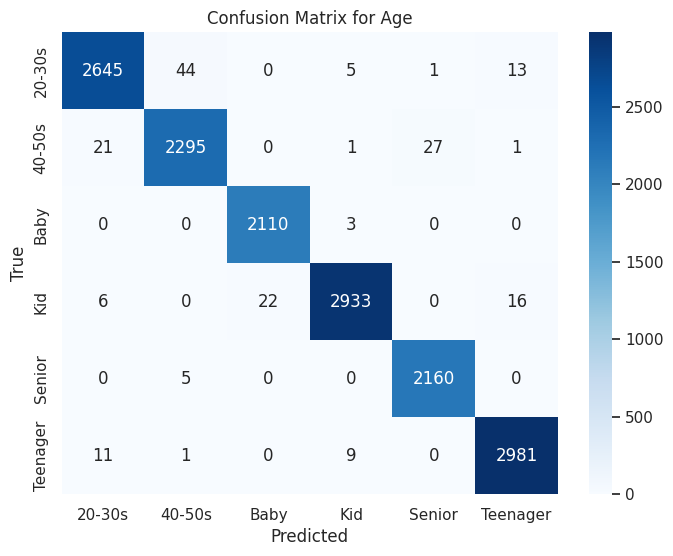

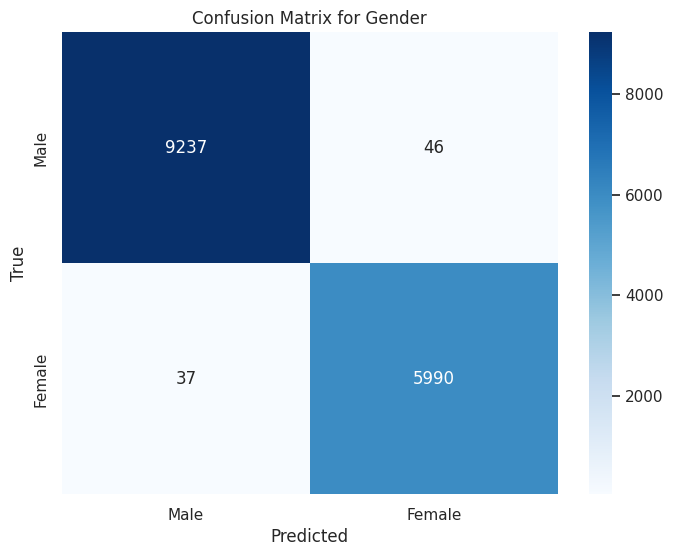

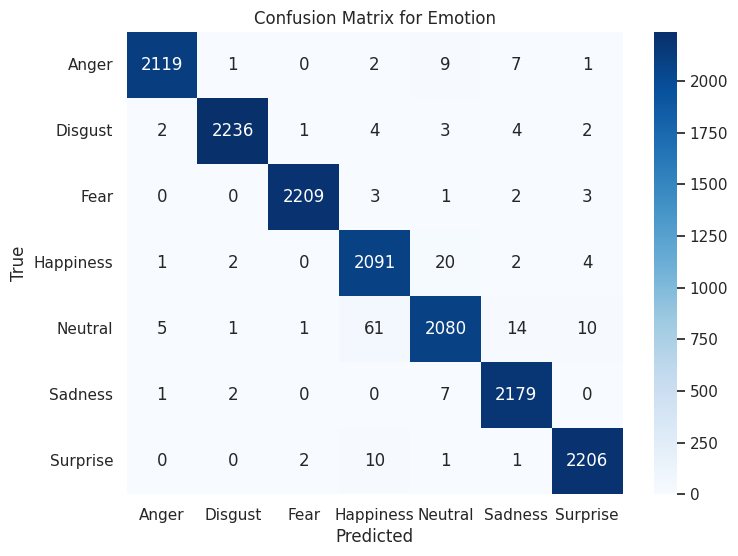

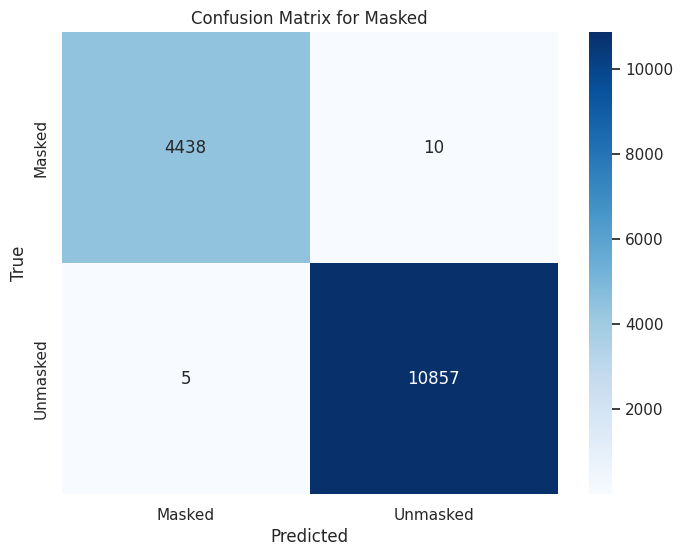

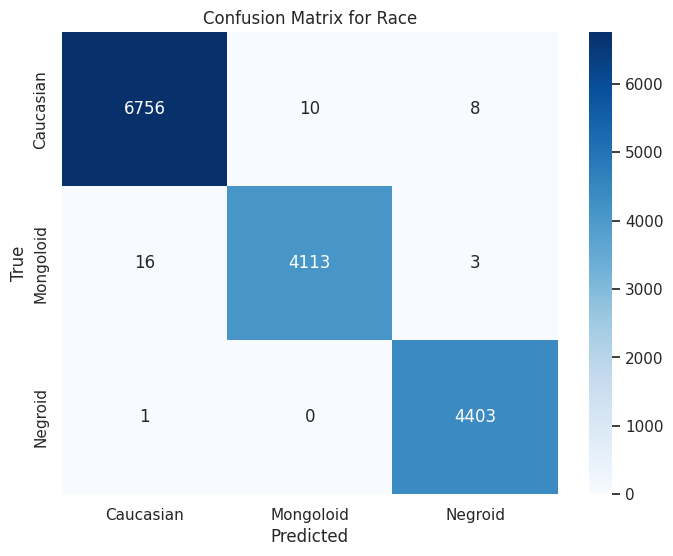

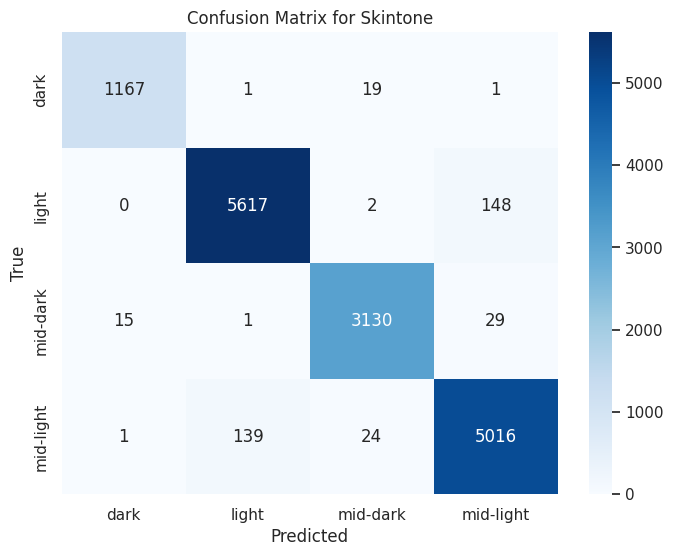

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, target_names, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix for age
plot_confusion_matrix(true_age_labels, predicted_age_labels, target_names=age_mapping.keys(), title='Confusion Matrix for Age')

# Plot confusion matrix for gender
plot_confusion_matrix(true_gender_labels, predicted_gender_labels, target_names=['Male', 'Female'], title='Confusion Matrix for Gender')

# Plot confusion matrix for emotion
plot_confusion_matrix(true_emotion_labels, predicted_emotion_labels, target_names=emotion_mapping.keys(), title='Confusion Matrix for Emotion')

# Plot confusion matrix for masked
plot_confusion_matrix(true_masked_labels, predicted_masked_labels, target_names=['Masked', 'Unmasked'], title='Confusion Matrix for Masked')

# Plot confusion matrix for race
plot_confusion_matrix(true_race_labels, predicted_race_labels, target_names=race_mapping.keys(), title='Confusion Matrix for Race')

# Plot confusion matrix for skintone
plot_confusion_matrix(true_skintone_labels, predicted_skintone_labels, target_names=skintone_mapping.keys(), title='Confusion Matrix for Skintone')